# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed  # force n2 import to avoid libgomp issue https://github.com/kakao/n2/issues/42

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `row_dict`. Therefore, `row_dict` will contain all rows from the dataset, i.e., all rows from both files.

We'll dynamically attribute an ID for each row using `enumerate`. entity-embed needs that too.

Also, to keep track of the IDs of each source file, we must keep a `left_id_set` and a `right_id_set`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['name'] = row.pop('title')  # in Amazon, name is called title
        row['__source'] = 'amazon'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        left_id_set.add(row['id'])

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['__source'] = 'google'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        right_id_set.add(row['id'])

Now we compute the `true_pair_set`:

In [9]:
true_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

Note internally entity-embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 entities. For example, a cluster with 3 entities means 2 entities from a file link to 1 row from the other file. This is not a problem for entity-embed. In fact, it's important for entity-embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_dict)

1105

In [11]:
cluster_dict[262]

[262, 2485, 2488]

In [12]:
for id_ in cluster_dict[262]:
    display(row_dict[id_])

{'id': 262,
 'description': 'sp linux we 50 lic/cd 3.0c',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 'name': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 '__source': 'amazon'}

{'id': 2485,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

{'id': 2488,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

Note that there are additional pairs in clusters when compared to `true_pair_set`. That's because it's useful for entity-embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results.

In [13]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - true_pair_set)

253

Clean up the temporary files:

In [14]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, strip leading and trailing whitespace, and limit any value to 100 tokens and 1000 chars to avoid memory errors.

The fields we'll clean are the ones we'll use:

In [15]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [16]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

It's worth noting you can use any alphabet you need, so this accent removal is optional.

## Configure entity-embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [17]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

Then we set an `attr_info_dict`. It defines types, which determine how attributes are processed in the neural network:

In [18]:
attr_info_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    }
}

In [21]:
import json

with open('../example-data/rl-example-attr-info.json', 'w') as f:
    json.dump(attr_info_dict, f, indent=4)

Then we use our `attr_info_dict` to get a `row_numericalizer`.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Also, one must keep this `row_numericalizer` to use on production data:

In [19]:
from entity_embed import AttrInfoDictParser

row_numericalizer = AttrInfoDictParser.from_dict(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

12:42:34 INFO:For attr=name, computing actual max_str_len
12:42:34 INFO:For attr=name, using actual_max_str_len=26
12:42:34 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
12:42:38 INFO:For attr=description, computing actual max_str_len
12:42:38 INFO:actual_max_str_len=29 must be even to enable NN pooling. Updating to 30
12:42:38 INFO:For attr=description, using actual_max_str_len=30
12:42:38 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
12:42:41 INFO:For attr=manufacturer, computing actual max_str_len
12:42:41 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
12:42:41 INFO:For attr=manufacturer, using actual_max_str_len=16
12:42:41 INFO:For attr=price, computing actual max_str_len
12:42:41 INFO:For attr=price, using actual_max_str_len=14


{'name': NumericalizeInfo(source_attr='name', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True),
 'semantic_name': NumericalizeInfo(source_attr='name', field_type=<FieldType.SEMANTIC_MULTITOKEN: 'semantic_multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

## Initialize Data Module

Under the hoods entity-embed uses [pytorch-lightning](https://www.pytorchlightning.ai/), so we need to create a datamodule object to split our dataset between train, valid, and test data.

In [20]:
clusters_total = len(cluster_dict)
clusters_total

1105

Since there's a lot of clusters, we'll use only 200 for training, and other 200 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for record linkage.

In [21]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
batch_size = 20
eval_batch_size = 50
datamodule = LinkageDataModule(
    row_dict=row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    true_pair_set=true_pair_set,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook Deduplication if you want to learn how to do it with entity-embed.

## Training

Now the training process! Thanks to pytorch-lightining, it's easy to train, validate, and test with the same datamodule.

We must choose the approximate nearest neighbors K, i.e., the top N our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [22]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    datamodule,
    ann_k=ann_k,
)

Inspecting the model will reveal it's built based on the attributes we set on `attr_info_dict`: 

In [23]:
model

LinkageEmbed(
  (blocker_net): BlockerNet(
    (embedding_net_dict): ModuleDict(
      (name): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (dense_net): Sequential(
            (0): Linear(in_features=7176, out_features=300, bias=True)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (semantic_name): MultitokenAttentionEmbed(
        (embedding_net): SemanticEmbedNet(
          (dense_net): Sequential(
            (0): Embedding(5565, 300)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (description): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1

To train, we use a [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/1.1.6/trainer.html).

As Entity Embed focus is on recall, we'll define an `EarlyStopping` by `valid_recall_at_0.3`.

`0.3` here is the threshold for cosine similarity of embedding vectors. Note we're using a validation metric, as the training process will run validation on every epoch due to `check_val_every_n_epoch=1`.

We also set a `TensorBoardLogger`, thus you can use `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics.

In [24]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_save_dir = 'tb_logs'
tb_name = 'amazon-google'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_save_dir, name=tb_name)
)

GPU available: True, used: True
12:42:42 INFO:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
12:42:42 INFO:TPU available: None, using: 0 TPU cores


OK, all set, call `fit`!

In [25]:
trainer.fit(model, datamodule)

12:42:42 INFO:Train pair count: 275
12:42:42 INFO:Valid pair count: 237
12:42:42 INFO:Test pair count: 830
12:42:42 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)
12:42:44 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Now training is done, we can easily check which attributes are most important for the final embedding:

In [26]:
model.blocker_net.get_signature_weights()

{'name': 0.2061237394809723,
 'semantic_name': 0.20058609545230865,
 'description': 0.16456085443496704,
 'semantic_description': 0.16881808638572693,
 'manufacturer': 0.12907062470912933,
 'price': 0.13084325194358826}

And we can check the best validation model:

In [27]:
from entity_embed import validate_best

validate_best(trainer)

{'valid_f1_at_0.3': 0.37599999999999995,
 'valid_f1_at_0.5': 0.7495741056218057,
 'valid_f1_at_0.7': 0.7647058823529412,
 'valid_f1_at_0.9': 0.3161512027491409,
 'valid_pair_entity_ratio_at_0.3': 2.323394495412844,
 'valid_pair_entity_ratio_at_0.5': 0.8027522935779816,
 'valid_pair_entity_ratio_at_0.7': 0.5481651376146789,
 'valid_pair_entity_ratio_at_0.9': 0.12385321100917432,
 'valid_precision_at_0.3': 0.23198420533070088,
 'valid_precision_at_0.5': 0.6285714285714286,
 'valid_precision_at_0.7': 0.7615062761506276,
 'valid_precision_at_0.9': 0.8518518518518519,
 'valid_recall_at_0.3': 0.9915611814345991,
 'valid_recall_at_0.5': 0.9282700421940928,
 'valid_recall_at_0.7': 0.7679324894514767,
 'valid_recall_at_0.9': 0.1940928270042194}

## Testing

With the best validation model (`ckpt_path='best'`), we can check the performance on the test set: 

In [28]:
trainer.test(ckpt_path='best', verbose=False)

12:44:33 INFO:Train pair count: 275
12:44:33 INFO:Valid pair count: 237
12:44:33 INFO:Test pair count: 830
12:44:33 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_f1_at_0.3': 0.1519291120546428,
  'test_f1_at_0.5': 0.4559252772913018,
  'test_f1_at_0.7': 0.6123622424532822,
  'test_f1_at_0.9': 0.34774609015639374,
  'test_pair_entity_ratio_at_0.3': 6.517263843648209,
  'test_pair_entity_ratio_at_0.5': 1.6912052117263843,
  'test_pair_entity_ratio_at_0.7': 0.8188925081433225,
  'test_pair_entity_ratio_at_0.9': 0.16742671009771987,
  'test_precision_at_0.3': 0.08226709316273491,
  'test_precision_at_0.5': 0.3008474576271186,
  'test_precision_at_0.7': 0.5083532219570406,
  'test_precision_at_0.9': 0.7354085603112841,
  'test_recall_at_0.3': 0.9915662650602409,
  'test_recall_at_0.5': 0.9409638554216867,
  'test_recall_at_0.7': 0.7698795180722892,
  'test_recall_at_0.9': 0.22771084337349398}]

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict`:

In [29]:
test_row_dict = datamodule.test_row_dict
test_left_id_set = set(id_ for id_ in left_id_set if id_ in test_row_dict)
test_right_id_set = set(id_ for id_ in right_id_set if id_ in test_row_dict)

Keep the `test_true_pair_set` in a variable for evaluation:

In [30]:
test_true_pair_set = datamodule.test_true_pair_set

Before testing manually, do some cleanup:

In [31]:
import gc
del trainer
del datamodule
gc.collect()
torch.cuda.empty_cache()

Then call `predict`:

In [32]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=test_left_id_set,
    right_id_set=test_right_id_set,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/31 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_left_vector_dict` and `test_right_vector_dict` have the same length of `test_row_dict`:

In [33]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

Now init an `ANNLinkageIndex`, insert all embeddings from both `test_left_vector_dict` and `test_right_vector_dict` on it, and build it:

In [34]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 408 ms, sys: 10 ms, total: 418 ms
Wall time: 66.4 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [35]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)

CPU times: user 640 ms, sys: 982 µs, total: 641 ms
Wall time: 86.5 ms


Let's check now the metrics of the found duplicate pairs:

In [36]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

6.517263843648209

In [37]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.08226709316273491, 0.9915662650602409)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [38]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

9181

In [39]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

7

In [40]:
cos_similarity = lambda a, b: np.dot(a, b)

In [41]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.39609146,
 {'id': 1078,
  'description': 'whether embarking on a serious building project or experimenting with home design ideas find everything needed in 3d home architect home designer version 8 . convenient wizards and tutorials help create basic plans fast while unlimited customization guarantees a flawless finished project . easy - to - use tabbed interface makes it easier to get started access and use tools and easier than ever to design a dream home !',
  'manufacturer': 'encore software',
  'price': '39 . 99',
  'name': '3d home architect home v . 8 by encore software',
  '__source': 'amazon'},
 {'id': 2398,
  'name': 'punch software 24100 - punch ! 5 in 1 home design - complete product - architectural - 1 user - complete productcomplete productstandard - pc',
  'description': 'punch software 24100 : power tools for serious home design plus ultimate deck for the perfect outdoor addition to your living space . p / p 5 powerful programs in one that launch from the same easy -

(0.30059323,
 {'id': 1064,
  'description': "introduce your child to an exciting on - screen learning environment brimming with award - winning adventures that will build essential skills while having fun . discover a learning adventure that ' s greater than fiction in the oregon trail ( r ). help the shipwrecked sleuths solve a mystery and escape before the volcano blows in cluefinders ( r ) adventures - secret of the living volcano expand your knowledge of u . s . geography tracking villains through all 50 states and learn regional history culture and music in where in the usa is carmen sandiego ( r",
  'manufacturer': 'encore software',
  'price': '19 . 99',
  'name': 'adventure workshop 4th - 6th grade 7th ed sb cs by riverdeep',
  '__source': 'amazon'},
 {'id': 2234,
  'name': 'school zone interactive math 2 on track software',
  'description': 'math 2 helps your child master second - grade math skills . engaging activities games and animated rewards make this electronic workbook 

(0.30684307,
 {'id': 978,
  'description': 'didi & ditto kindergarten is a wacky fun - filled learning adventure that kids will love . didi and ditto are twin beavers who live in a colorful forest . when a purple wolf catches one of them the other has to collect enough food to free their trapped beaver sibling ! ages 4 to 6',
  'manufacturer': 'kutoka',
  'price': '19 . 99',
  'name': 'didi & ditto : kindergarten win / mac',
  '__source': 'amazon'},
 {'id': 2948,
  'name': 'microsoft office and windows training ( win 98 me nt 2000 xp )',
  'description': 'for almost two decades learn2 has helped over 8000000 consumers including professionals from fortune 500 companies and government agencies to enhance their computer skills . now learn2 offers the same innovative virtual curriculum to newcomers ...',
  'manufacturer': '',
  'price': '29 . 95',
  '__source': 'google'})

In [42]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.085495636,
 {'id': 432,
  'description': 'model - suscd000516wi vendor - susteen features - datapilot universal pro dp300 - x03p kit datapilot universal pro is the most robust data management solution which allows you to sync and individualize your mobile phone and ipod content from your pc or mac . universal pro goes beyond data transfer to provide charging functionality of your mobile phone and ipod battery via the data cables plugged in your computer . includes datapilot software cd for macintosh and windows ( 7 ) phone connectors bluetooth adapter ipod cable user guide . * universal pro cable system - it contains 7 phone',
  'manufacturer': 'susteen',
  'price': '113 . 1',
  'name': 'cell phone software solution',
  '__source': 'amazon'},
 {'id': 3611,
  'name': 'datapilot universal pro kit ( win 2000 xp vista / mac 10 . 3 . 8 or later )',
  'description': 'kit includes software bluetooth adapter multiple cell phone connectors and ipod adapter . mobile phone synchronization tool

(0.2761494,
 {'id': 728,
  'description': 'firstedge 2 helps you keep your business checking accounts in order . it provides all the basic accounting and business management needs of your small business in an easy to use easy to understand package . track your expenses create sales invoices keep your customer information handy and provide all the reports you or your accountant need for tax reporting . a host of preferences under the setup menu lets you perform you accounting and management chores your way',
  'manufacturer': 'myob us',
  'price': '99 . 95',
  'name': 'firstedge v 2 . 0 ( mac )',
  '__source': 'amazon'},
 {'id': 1801,
  'name': 'myob firstedge',
  'description': "grab your first edge in business by positioning yourself for success . you don ' t need to know accounting or even care about accounting to know that your business future depends largely on good financial organization that lets you know where your ...",
  'manufacturer': '',
  'price': '99 . 99',
  '__source': 

(-0.053237155,
 {'id': 845,
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today ' s mac including garageband itunes and iweb . now aspiring musicians have everything they need to learn guitar play and sing popular songs and easily create their own performances . users can view lessons or listen to their new performances in itunes or on their ipod",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99',
  'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  '__source': 'amazon'},
 {'id': 2324,
  'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive space',
  'manufacturer': '',
  'price': '28 . 99',
  '__source': 'google'})

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [43]:
vis_sample_size = 10

In [44]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
__, test_cluster_dict = id_pairs_to_cluster_mapping_and_dict(test_true_pair_set)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [45]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [46]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

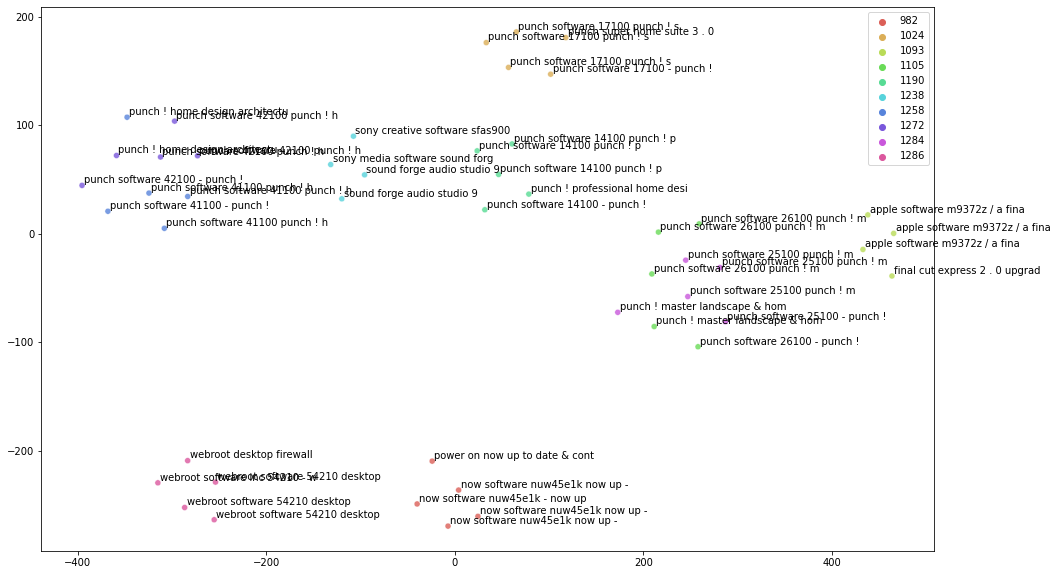

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)